In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data Augmentation-XrayImg


In [ ]:
#!unzip XRAYBoneDataset.zip

Archive:  XRAYBoneDataset.zip
replace XRAYBoneDataset/train/JPEGImages/finger_2119_image2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#0. Setup

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirementsa/build.txt
!pip install -v -e .
!mkdir checkpoints/ 

In [ ]:
%cd mmdetection/

[Errno 2] No such file or directory: 'mmdetection/'
/content/gdrive/MyDrive/Data Augmentation-XrayImg/mmdetection


In [4]:
import torch
import torchvision
from torch.utils.data import Dataset
import os
import glob
import cv2
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from matplotlib import patches
import numpy as np 
import mmcv

In [5]:
train_annotations_path='../XRAYBoneDataset/annotations/instances_train.json'
val_annotations_path='../XRAYBoneDataset/annotations/instances_val.json'
test_annotations_path='../XRAYBoneDataset/annotations/instances_test.json'

train_images_path='../XRAYBoneDataset/train/JPEGImages'
val_images_path='../XRAYBoneDataset/val/JPEGImages'
test_images_path='../XRAYBoneDataset/test/JPEGImages'

#!mkdir ../XRAYBoneDataset/train/save_JPEGImages
#!mkdir ../XRAYBoneDataset/val/save_JPEGImages
#!mkdir ../XRAYBoneDataset/test/save_JPEGImages

save_train_images_folder='../XRAYBoneDataset/train/save_JPEGImages'
save_val_images_folder='../XRAYBoneDataset/val/save_JPEGImages'
save_test_images_folder='../XRAYBoneDataset/test/save_JPEGImages'


EPOCH_N=1
BATCH_SIZE=32


# 1. Utils

In [6]:
def read_json(path):
  with open(path,'r') as f:
    data=json.load(f)
  return data


def save_json(path,data):
  with open(path,'w') as f:
    json.dump(data,f,indent=4)
    

In [7]:
data=read_json(train_annotations_path)

In [8]:
print(data['categories'])

[{'supercategory': None, 'id': 0, 'name': '_background_'}, {'supercategory': None, 'id': 1, 'name': 'bone'}]


# 2. Train

In [9]:
!wget -P ./checkpoints/ http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-04-07 08:06:54--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

mask_rcnn_r50_caffe 100%[===================>] 169.63M  8.54MB/s    in 21s     

2021-04-07 08:07:16 (8.26 MB/s) - ‘./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [ ]:
# TRAIN
!python3 ./tools/train.py ../train_xray_segm.py

In [ ]:
#TEST
!python3 ./tools/test.py ../train_xray_segm.py ./work_dirs/train_xray_segm/latest.pth --eval bbox segm

In [18]:
!cp ./work_dirs/train_xray_segm/latest.pth -r ../../

In [11]:
def convert_bin(result):
  x=result[1][0][0]
  new_result=[]
  for i in range(len(x)):
    new_x=[]
    for j in range(len(x[i])):
      if x[i][j]:
        new_x.append(1)
      else:
        new_x.append(0)
    new_result.append(new_x)
  return new_result # mask
      

def remove_background(img,mask):
  
  img=np.transpose(img, (2, 0, 1))
  for channel in img:
    for i in range(len(channel)):
      for j in range(len(channel[i])):
        if mask[i][j]==0:
          channel[i][j]=0
  
  return np.transpose(img, (1, 2, 0))




Use load_from_local loader


/content/gdrive/My Drive/Data Augmentation-XrayImg/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


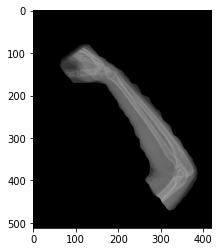

In [14]:
# demo img
%matplotlib inline
from mmdet.apis import init_detector, inference_detector
image_paths = glob.glob(os.path.join(test_images_path,'*.jpg'))
config_file = '../train_xray_segm.py'
checkpoint_file = './work_dirs/train_xray_segm/latest.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
path = next(iter(image_paths))
img=cv2.imread(path)
result=inference_detector(model, path)
new_re=convert_bin(result)
new_re=np.array(new_re)
new_re=remove_background(img,new_re)
plt.imshow(new_re)
plt.show()


In [15]:

def save_new_img(original_img_paths,save_img_folder):
  image_paths = glob.glob(os.path.join(original_img_paths,'*.jpg'))
  for i,img_path in enumerate(image_paths):
    img=cv2.imread(img_path)
    result=inference_detector(model, img_path)
    new_re=convert_bin(result)
    new_re=np.array(new_re)
    new_re=remove_background(img,new_re)
    clahe_img=equalize_clahe_color(new_re)
    save_img_path=os.path.join(save_img_folder,'%d.jpg'%i)
    cv2.imwrite(save_img_path,clahe_img)

def equalize_clahe_color(img):
    cla = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(18, 18))
    channels = cv2.split(img)
    eq_channels = []
    for ch in channels:
        eq_channels.append(cla.apply(ch))

    eq_image = cv2.merge(eq_channels)
    return eq_image

In [16]:
# save_new_img(test_images_path,save_test_images_folder)
# save_new_img(val_images_path,save_val_images_folder)
# save_new_img(train_images_path,save_train_images_folder)

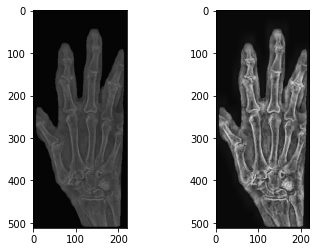

In [17]:
image_paths = glob.glob(os.path.join(save_test_images_folder,'*.jpg'))
path = next(iter(image_paths))
image = cv2.imread(path)
clahe_img=equalize_clahe_color(image)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(clahe_img)
plt.show()
